In [101]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np

#I knew some things about numerical analysis it was my SoS
def numerical_derivative(arr, dt):
    deriv = np.zeros_like(arr)

    # Forward difference for the first element
    deriv[0] = (arr[1] - arr[0]) / dt

    # Central difference for interior elements
    deriv[1:-1] = (arr[2:] - arr[:-2]) / (2 * dt)

    # Set last derivative equal to second-last one
    deriv[-1] = deriv[-2]

    return deriv


# Constants
g = 9.81
L = 5.0

# Initial conditions
theta0_val = 0.96
omega0_val = 0.0

theta0 = torch.tensor([[theta0_val]], dtype=torch.float32).to(device)
omega0 = torch.tensor([[omega0_val]], dtype=torch.float32).to(device)

# Initial total energy
E0 = 0.5 * omega0**2 + g * (1 - torch.cos(theta0))

# PINN model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128,1)
        )

    def forward(self, t):
        return self.net(t)

# Physics loss: θ'' + (g/L) sin(θ) = 0
def physics_loss(model, t):
    t = t.clone().detach().requires_grad_(True)
    theta = model(t)
    dtheta_dt = torch.autograd.grad(theta, t, torch.ones_like(theta), create_graph=True)[0]
    d2theta_dt2 = torch.autograd.grad(dtheta_dt, t, torch.ones_like(dtheta_dt), create_graph=True)[0]
    residual = d2theta_dt2 + (g / L) * torch.sin(theta)
    return torch.mean(residual**2)

# Initial condition loss
def initial_loss(model):
    t0 = torch.tensor([[0.0]], device=device, requires_grad=True)
    theta_pred = model(t0)
    dtheta_dt = torch.autograd.grad(theta_pred, t0, torch.ones_like(theta_pred), create_graph=True)[0]
    return (theta_pred - theta0).pow(2).mean() + (dtheta_dt - omega0).pow(2).mean()

# Energy loss: penalize deviation from initial energy
def energy_loss(model, t):
    t = t.clone().detach().requires_grad_(True)
    theta = model(t)
    dtheta_dt = torch.autograd.grad(theta, t, torch.ones_like(theta), create_graph=True)[0]
    energy = 0.5 * dtheta_dt**2 + g * (1 - torch.cos(theta))
    return torch.mean((energy - E0).pow(2))

# Model and optimizer
model = PINN().to(device)

# Better initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1.5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

# Training data
t_train = torch.linspace(0, 10, 1250).view(-1, 1).to(device)

lossarray=np.zeros(5000)

# Training loop
for epoch in range(5000):
    optimizer.zero_grad()
    loss = 1.9*physics_loss(model, t_train) + initial_loss(model) + 0.1 * energy_loss(model, t_train)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, LR: {scheduler.get_last_lr()[0]:.6e}")
    lossarray[epoch]=loss.item()


# Prediction
t_test = torch.linspace(0, 10, 1250).view(-1, 1).to(device)
t_test.requires_grad_(True)
theta_tensor = model(t_test)
dtheta_dt = torch.autograd.grad(theta_tensor, t_test, torch.ones_like(theta_tensor), create_graph=True)[0]

# Convert to numpy
theta_np = theta_tensor.detach().cpu().numpy().flatten()
dtheta_np = dtheta_dt.detach().cpu().numpy().flatten()


Epoch 0, Loss: 2.837360, LR: 1.500000e-03
Epoch 500, Loss: 1.024552, LR: 7.500000e-04
Epoch 1000, Loss: 0.347510, LR: 3.750000e-04
Epoch 1500, Loss: 0.301973, LR: 1.875000e-04
Epoch 2000, Loss: 0.297879, LR: 9.375000e-05
Epoch 2500, Loss: 0.297474, LR: 4.687500e-05
Epoch 3000, Loss: 0.297367, LR: 2.343750e-05
Epoch 3500, Loss: 0.297325, LR: 1.171875e-05
Epoch 4000, Loss: 0.297304, LR: 5.859375e-06
Epoch 4500, Loss: 0.297293, LR: 2.929688e-06


In [102]:

# Compute ω using energy and sign
omega_np=numerical_derivative(theta_np,t_train[1]-t_train[0])

/var/folders/ld/sbsgc0h10cb4svd48npnbr3w0000gn/T/ipykernel_16616/2656500809.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  deriv[1:-1] = (arr[2:] - arr[:-2]) / (2 * dt)


In [103]:

### SIMULATING NUMERICALLY NOW FOR COMPARISON

# Initial conditions
theta0 = theta0_val # initial angle
omega0 = omega0_val        # initial angular velocity

# Time settings
t0 = 0
t_end = 10
dt = 0.01
N = int((t_end - t0) / dt)

# Arrays to store results
t = np.linspace(t0, t_end, N)
theta = np.zeros(N)
omega = np.zeros(N)

# Set initial values
theta[0] = theta0
omega[0] = omega0

# derivatives
def f_theta(theta, omega):
    return omega

def f_omega(theta, omega):
    return - (g / L) * np.sin(theta)

# Runge-Kutta-4
#We decompose the single double differential equation to 2 first order differential equations and solve them numerically
for i in range(1, N):
    k1_theta = dt * f_theta(theta[i-1], omega[i-1])
    k1_omega = dt * f_omega(theta[i-1], omega[i-1])

    k2_theta = dt * f_theta(theta[i-1] + 0.5*k1_theta, omega[i-1] + 0.5*k1_omega)
    k2_omega = dt * f_omega(theta[i-1] + 0.5*k1_theta, omega[i-1] + 0.5*k1_omega)

    k3_theta = dt * f_theta(theta[i-1] + 0.5*k2_theta, omega[i-1] + 0.5*k2_omega)
    k3_omega = dt * f_omega(theta[i-1] + 0.5*k2_theta, omega[i-1] + 0.5*k2_omega)

    k4_theta = dt * f_theta(theta[i-1] + k3_theta, omega[i-1] + k3_omega)
    k4_omega = dt * f_omega(theta[i-1] + k3_theta, omega[i-1] + k3_omega)

    theta[i] = theta[i-1] + (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta) / 6
    omega[i] = omega[i-1] + (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega) / 6




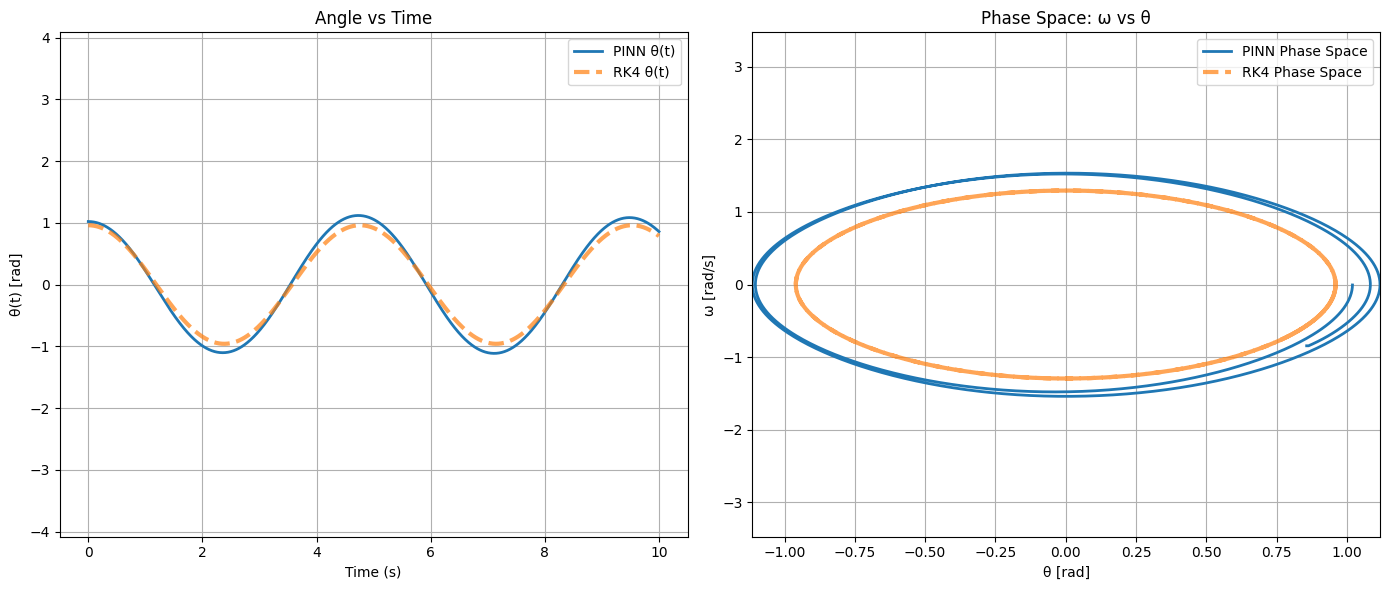

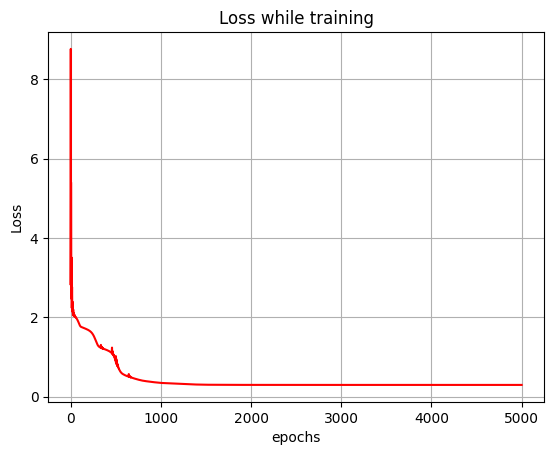

In [108]:

#PLOTTING

t_rk4=t
theta_rk4=theta
omega_rk4=omega

plt.figure(figsize=(14, 6))

# Angle vs Time
plt.subplot(1, 2, 1)
plt.plot(t_test.cpu().detach().numpy(), theta_np, label="PINN θ(t)", linewidth=2)
plt.plot(t_rk4, theta_rk4, label="RK4 θ(t)", linestyle='--', alpha=0.7,linewidth = 3)
plt.xlabel("Time (s)")
plt.ylabel("θ(t) [rad]")
plt.title("Angle vs Time")
plt.legend()
plt.grid()
plt.ylim(-1.3 * np.pi, 1.3 * np.pi)

# Phase space: omega vs theta
plt.subplot(1, 2, 2)
plt.plot(theta_np, omega_np, label="PINN Phase Space", linewidth=2)
plt.plot(theta_rk4, omega_rk4, label="RK4 Phase Space", linestyle='--', alpha=0.7,linewidth = 3)
plt.xlabel("θ [rad]")
plt.ylabel("ω [rad/s]")
plt.title("Phase Space: ω vs θ")
plt.legend()
plt.grid()
plt.xlim(min(min(theta_np), min(theta_rk4)), max(max(theta_np), max(theta_rk4)))
plt.ylim(-np.sqrt(2 * E0.item()) * 1.2, np.sqrt(2 * E0.item()) * 1.2)

plt.tight_layout()
plt.show()

plt.plot(np.linspace(1,5000,5000),lossarray, color='red')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title("Loss while training")
plt.show()

